<a href="https://colab.research.google.com/github/ramsunder2000/DataScience/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
DF= pd.read_csv('/content/drive/MyDrive/Time Series Datasets/Electric_Production.csv')

In [ ]:
DF.isna().sum()

,0
DATE,0
IPG2211A2N,0


In [ ]:
DF = DF.rename(columns={'DATE':'ds','IPG2211A2N':'ts'})

In [ ]:
DF.head(3)

,ds,ts
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502


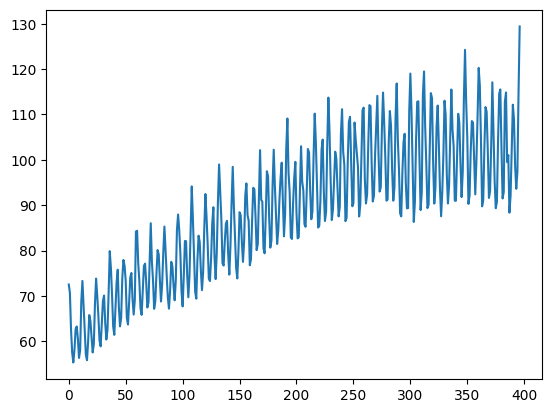

In [ ]:
plt.figure()
plt.plot(DF.ts)

In [ ]:
DF.describe()

,ts
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


Stabilize variance, make patterns more linear, use log transformation

In [ ]:
## Log transformations to possitive and grater than zero....

In [ ]:
def log_trans(df,ts):
  return df[ts].apply(lambda x: np.log(x))

In [ ]:
DF['ts_log'] = log_trans(DF,'ts')
DF.head()

,ds,ts,ts_log
0,1/1/1985,72.5052,4.283658
1,2/1/1985,70.6720,4.258049
2,3/1/1985,62.4502,4.134369
3,4/1/1985,57.4714,4.051287
4,5/1/1985,55.3151,4.013046


SEASONAL DECOMPOSITION

In [ ]:
## Trying to understand

decomposition = seasonal_decompose(DF.ts_log,period=48, extrapolate_trend=1)

In [ ]:
def plot_decomposition(df,ts,trend,seasonal,residual):
  f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,5),sharex=True)

  ax1.plot(df[ts],label='Original')
  ax1.legend(loc='best')
  ax1.tick_params(axis='x',rotation=45)

  ax2.plot(df[trend],label='Trend')
  ax2.legend(loc='best')
  ax2.tick_params(axis='x',rotation=45)

  ax3.plot(df[seasonal],label='Seasonal')
  ax3.legend(loc='best')
  ax3.tick_params(axis='x',rotation=45)

  ax4.plot(df[residual],label='Residual')
  ax4.legend(loc='best')
  ax4.tick_params(axis='x',rotation=45)

  plt.tight_layout()
  plt.show()

In [ ]:
New_Df = DF.copy()

New_Df.loc[:,'trend'] = decomposition.trend
New_Df.loc[:,'seasonal'] = decomposition.seasonal
New_Df.loc[:,'residual'] = decomposition.resid

In [ ]:
New_Df.head()

,ds,ts,ts_log,trend,seasonal,residual
0,1/1/1985,72.5052,4.283658,4.133395,0.144414,0.005849
1,2/1/1985,70.6720,4.258049,4.132239,0.068252,0.057558
2,3/1/1985,62.4502,4.134369,4.131082,-0.001020,0.004307
3,4/1/1985,57.4714,4.051287,4.129926,-0.106119,0.027481
4,5/1/1985,55.3151,4.013046,4.128770,-0.106471,-0.009253


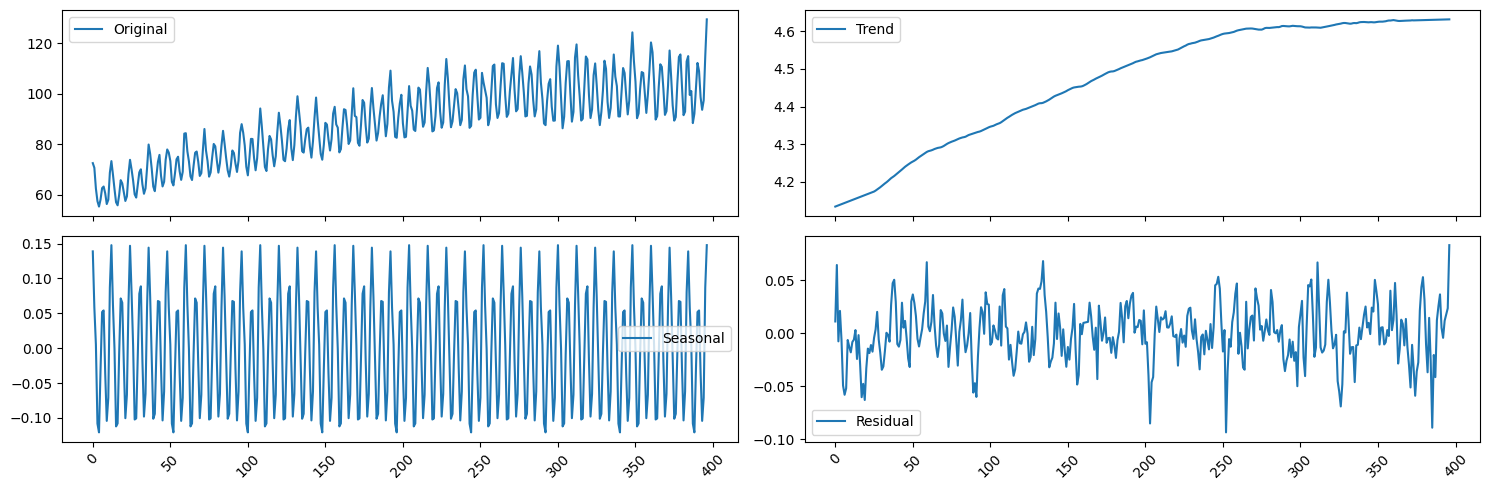

In [ ]:
plot_decomposition(New_Df,'ts','trend','seasonal','residual')

Test for Stationarity

Dickey Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
dftest = adfuller(New_Df.residual,autolag='AIC')

In [ ]:
dftest

(np.float64(-5.309598812802486),
 np.float64(5.230453680218215e-06),
 15,
 381,
 {'1%': np.float64(-3.4476305904172904),
  '5%': np.float64(-2.869155980820355),
  '10%': np.float64(-2.570827146203181)},
 np.float64(-1838.4910848413392))

In [ ]:
def test_stationarity(timeseries):

  #Determing rolling statistics
  rolmean = timeseries.rolling(window=12,center=False).mean()
  rolstd = timeseries.rolling(window=12,center=False).std()

  orig= plt.plot(timeseries,color='blue',label='Original')
  mean = plt.plot(rolmean,color='red',label='Rolling Mean')
  std = plt.plot(rolstd,color='black',label='Rolling Std')

  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.xticks(rotation=45)
  plt.show(block=False)
  plt.close()

  print('Result:')
  dftest = adfuller(timeseries,autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)



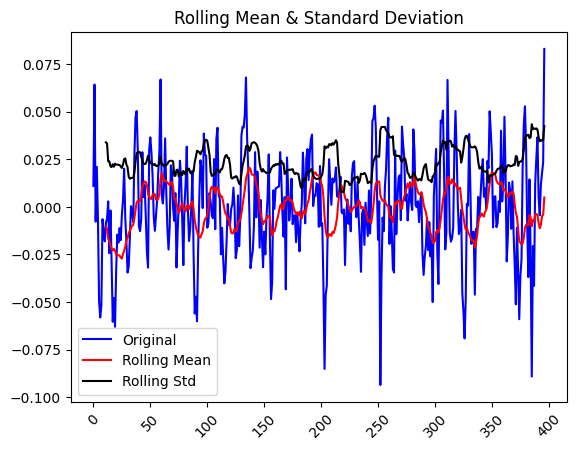

Result:
Test Statistic                  -5.309599
p-value                          0.000005
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [ ]:
test_stationarity(New_Df.residual)

p < 0.05

p---Auto Regression ----How many values going to influence current value
d--- Degree of diffrencing  - 0 if it is stationary
q(MA) - Moving Average